# Data Cleaning & Imputing & Treatment

In [ ]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from unidecode import unidecode
import time
import re
from pathlib import Path

In [ ]:
# Load datasets - Update the paths to reflect the new mountpoint
DATA_DIR = Path(r"C:\Users\utaka\MLOPS\Final Assignment\MLOpsProject\data")

train_raw = pd.read_csv(DATA_DIR / "train_raw.csv")
test_raw  = pd.read_csv(DATA_DIR / "test_raw.csv")

train = train_raw.copy()
test  = test_raw.copy()

# Drop weight column since all house weights are equal 
train.drop(columns=['w'], inplace=True)

## 1 - Availability

In [181]:
train['availability'] = train['availability'].fillna('unknown')
test['availability'] = test['availability'].fillna('unknown')


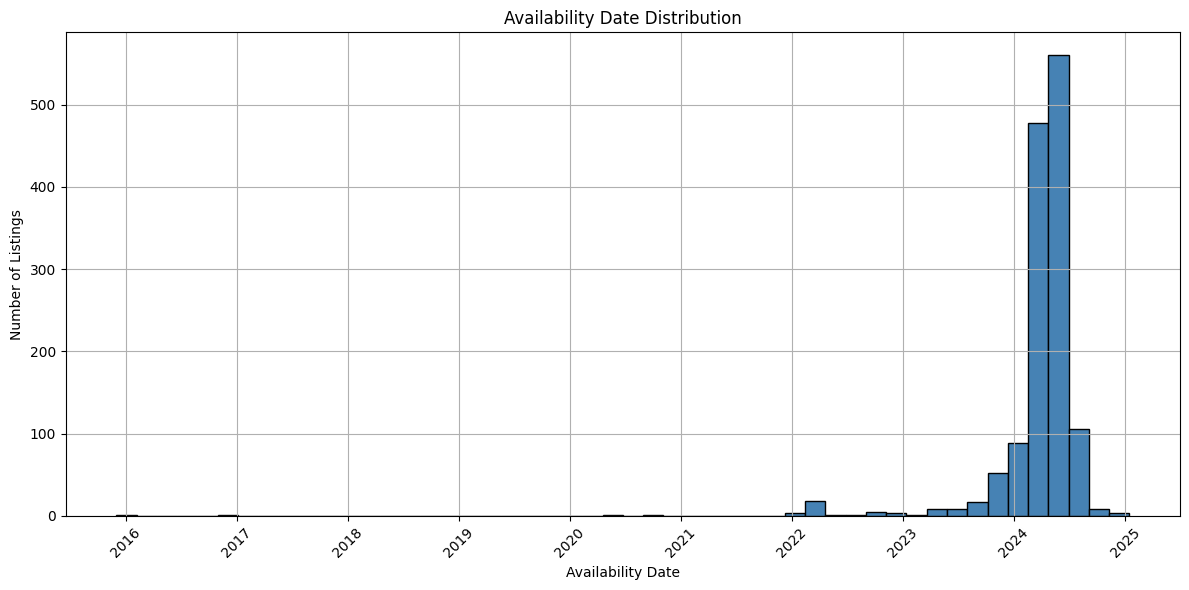

Outliers before 2022: 4 rows
<DatetimeArray>
['2015-12-01 00:00:00', '2016-11-21 00:00:00', '2020-06-03 00:00:00',
 '2020-09-18 00:00:00']
Length: 4, dtype: datetime64[ns]

Outliers after 2025: 1 rows
<DatetimeArray>
['2025-01-15 00:00:00']
Length: 1, dtype: datetime64[ns]


In [ ]:
# Function to extract date from 'available from DD/MM/YYYY'
def extract_availability_date(val):
    try:
        if isinstance(val, str) and "available from" in val.lower():
            date_str = val.lower().replace("available from", "").strip()
            return pd.to_datetime(date_str, dayfirst=True, errors='coerce')
        return pd.NaT
    except:
        return pd.NaT

# Apply to both datasets
train['availability_date'] = train['availability'].apply(extract_availability_date)
test['availability_date'] = test['availability'].apply(extract_availability_date)

# Combine dates
all_dates = pd.concat([train['availability_date'], test['availability_date']]).dropna()

In [188]:
# Define valid range
min_valid = pd.to_datetime("2022-01-01")
max_valid = pd.to_datetime("2024-12-31")

train = train[(train['availability_date'].isna()) |
              ((train['availability_date'] >= min_valid) &
               (train['availability_date'] <= max_valid))].copy()

# Create binary flag
train['is_available'] = train['availability'].apply(
    lambda x: 1 if isinstance(x, str) and x.strip().lower() == 'available' else 0
)
test['is_available'] = test['availability'].apply(
    lambda x: 1 if isinstance(x, str) and x.strip().lower() == 'available' else 0
)

In [190]:
print("\nMissing values summary after handling 'availability':")
print("\nMissing in Train:\n", train.isnull().sum())
print("\nMissing in Test:\n", test.isnull().sum())



Missing values summary after handling 'availability':

Missing in Train:
 w                             0
y                             0
square_meters                 0
contract_type                 0
availability                  0
description                   0
other_features                8
conditions                  109
floor                         6
elevator                      0
energy_efficiency_class     378
condominium_fees            197
zone                          0
availability_date          3658
is_available                  0
dtype: int64

Missing in Test:
 square_meters                 0
contract_type                 0
availability                  0
description                   0
other_features                4
conditions                   79
floor                         1
elevator                      0
energy_efficiency_class     226
condominium_fees            124
zone                          0
availability_date          2309
is_available                 

In [191]:
avail_map = {'available': 2, 'unknown': 1, 'not available': 0}
train['availability_encoded'] = train['availability'].fillna('unknown').map(avail_map)
test['availability_encoded'] = test['availability'].fillna('unknown').map(avail_map)


In [192]:
# Replace NaN values in 'availability_encoded' with 0
# Ensures consistent encoding for entries originally labeled as 'available from date' or missing values
train['availability_encoded'] = train['availability_encoded'].fillna(0)
test['availability_encoded'] = test['availability_encoded'].fillna(0)

## 2 - Energy Efficiency Class

In [200]:
# Step 1: Define energy score mapping
energy_map = {'a': 7, 'b': 6, 'c': 5, 'd': 4, 'e': 3, 'f': 2, 'g': 1, 'unknown': None}

# Step 2: Map values to energy_class_num
train['energy_class_num'] = train['energy_efficiency_class'].map(energy_map)
test['energy_class_num'] = test['energy_efficiency_class'].map(energy_map)

# Step 3: Create group means from available (non-null) rows in train
cond_avg = train.loc[train['energy_class_num'].notna()].groupby('conditions')['energy_class_num'].mean()
zone_avg = train.loc[train['energy_class_num'].notna()].groupby('zone')['energy_class_num'].mean()

# Step 4: Define imputation function
def impute_energy(row):
    if pd.notna(row['energy_class_num']):
        return row['energy_class_num']
    cond_val = cond_avg.get(row['conditions'])
    if pd.notna(cond_val):
        return cond_val
    zone_val = zone_avg.get(row['zone'])
    if pd.notna(zone_val):
        return zone_val
    return 4  # fallback average if nothing else available

# Step 5: Apply to train and test
train['energy_class_num'] = train.apply(impute_energy, axis=1)
test['energy_class_num'] = test.apply(impute_energy, axis=1)

# Step 6: Final formatting
train['energy_efficiency_class_encoded'] = train['energy_class_num'].round().clip(1, 7).astype(int)
test['energy_efficiency_class_encoded'] = test['energy_class_num'].round().clip(1, 7).astype(int)


## 3 - Conditions

In [206]:
# For train: use price proximity to impute
def refined_impute_condition_train(row):
    if pd.notna(row['conditions']):
        return row['conditions']

    candidates = condition_ref[
        (condition_ref['zone'] == row['zone']) &
        (condition_ref['energy_efficiency_class_encoded'] == row['energy_efficiency_class_encoded'])
    ]

    if not candidates.empty:
        closest = candidates.iloc[(candidates['median_rent'] - row['y']).abs().argsort()[:1]]
        return closest['conditions'].values[0]

    # fallback: most frequent in train
    return train['conditions'].mode().iloc[0]

train['conditions'] = train.apply(refined_impute_condition_train, axis=1)

# For test: no rent available, fallback to most frequent
def refined_impute_condition_test(row):
    if pd.notna(row['conditions']):
        return row['conditions']

    match = fallback_ref[
        (fallback_ref['zone'] == row['zone']) &
        (fallback_ref['energy_efficiency_class_encoded'] == row['energy_efficiency_class_encoded'])
    ]

    if not match.empty:
        return match['conditions'].values[0]

    return train['conditions'].mode().iloc[0]  # fallback

test['conditions'] = test.apply(refined_impute_condition_test, axis=1)


In [209]:
# Define ordinal mapping (lowest = worst, highest = best)
condition_map = {
    'good condition': 0,
    'excellent': 1,
    'new': 2
}

# Apply mapping
train['conditions_encoded'] = train['conditions'].map(condition_map)
test['conditions_encoded'] = test['conditions'].map(condition_map)


## 4- Floor

In [213]:
# Grouped mode lookup
floor_mode_by_group = (
    train.groupby(['zone', 'elevator'])['floor']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    .reset_index()
)

# Define function
def impute_floor(row, df_lookup):
    if pd.notna(row['floor']):
        return row['floor']
    match = df_lookup[
        (df_lookup['zone'] == row['zone']) &
        (df_lookup['elevator'] == row['elevator'])
    ]
    if not match.empty:
        return match['floor'].values[0]
    return train['floor'].mode().iloc[0]  # fallback

# Apply to both datasets
train['floor'] = train.apply(lambda row: impute_floor(row, floor_mode_by_group), axis=1)
test['floor'] = test.apply(lambda row: impute_floor(row, floor_mode_by_group), axis=1)


In [215]:
# Define mapping
floor_map = {
    'Semi-basement': -1,
    'Ground floor': 0,
    'Mezzanine': 0.5,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    '7': 7,
    '8': 8,
    '9': 9
}

# Apply to both datasets
train['floor_num'] = train['floor'].map(floor_map)
test['floor_num'] = test['floor'].map(floor_map)


In [218]:
# Step 1: Encode elevator as 1 (yes) and -1 (no)
train['elevator_sign'] = train['elevator'].map({'yes': 1, 'no': -1})
test['elevator_sign'] = test['elevator'].map({'yes': 1, 'no': -1})

# Step 2: Create interaction feature: floor × elevator_sign
# (Assumes 'floor' has already been mapped to numeric values)
train['floor_effect'] = train['floor_num'] * train['elevator_sign']
test['floor_effect'] = test['floor_num'] * test['elevator_sign']


## 5 - Description

In [ ]:
def parse_description(text):
    text = str(text).lower()
    features = {
        'total_rooms': None,
        'num_bedrooms': 0,
        'num_other_rooms': 0,
        'num_bathrooms': 0,
        'kitchen_open': 0,
        'kitchen_diner': 0,
        'kitchen_nook': 0,
        'kitchen_semi': 0,
        'kitchenette': 0,
        'kitchen_none': 1,
        'suitable_disabled': int('suitable for disabled' in text)
    }

    # Total rooms
    match_total = re.search(r'(\d+)\s*(?:rooms|\()', text)
    if match_total:
        features['total_rooms'] = int(match_total.group(1))

    # Bedrooms and other rooms
    match_bed = re.search(r'(\d+)\s*bedrooms?', text)
    match_other = re.search(r'(\d+)\s*others?', text)
    if match_bed:
        features['num_bedrooms'] = int(match_bed.group(1))
    if match_other:
        features['num_other_rooms'] = int(match_other.group(1))

    # Bathrooms
    match_bath = re.search(r'(\d+)[\+]*\s*bathrooms?', text)
    if match_bath:
        features['num_bathrooms'] = int(match_bath.group(1))

    # Kitchen type
    kitchen_patterns = {
    'kitchen_open': r'\bopen kitchen\b',
    'kitchen_diner': r'\bkitchen diner\b',
    'kitchen_nook': r'\bkitchen nook\b',
    'kitchen_semi': r'\bsemi[-\s]?habitable kitchen\b',
    'kitchenette': r'\bkitchenette\b'}

    # Check each pattern
    for key, pattern in kitchen_patterns.items():
        if re.search(pattern, text):
            features[key] = 1
            features['kitchen_none'] = 0

    return pd.Series(features)

# Apply to both train and test sets
train = train.join(train['description'].apply(parse_description))
test = test.join(test['description'].apply(parse_description))


In [230]:
mismatch['total_rooms'].mean()

2.388888888888889

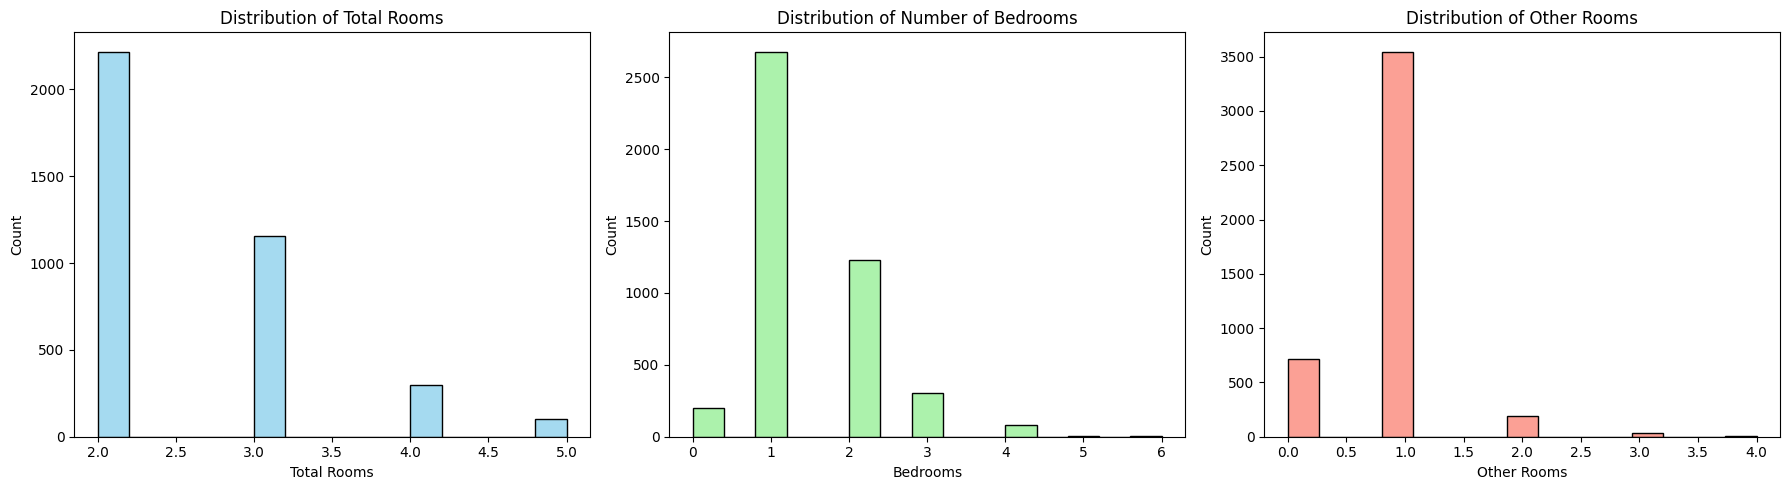

In [231]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distributions of total_rooms, num_bedrooms, and num_other_rooms
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(train['total_rooms'].dropna(), bins=15, kde=False, ax=axs[0], color='skyblue')
axs[0].set_title('Distribution of Total Rooms')
axs[0].set_xlabel('Total Rooms')

sns.histplot(train['num_bedrooms'].dropna(), bins=15, kde=False, ax=axs[1], color='lightgreen')
axs[1].set_title('Distribution of Number of Bedrooms')
axs[1].set_xlabel('Bedrooms')

sns.histplot(train['num_other_rooms'].dropna(), bins=15, kde=False, ax=axs[2], color='salmon')
axs[2].set_title('Distribution of Other Rooms')
axs[2].set_xlabel('Other Rooms')

plt.tight_layout()
plt.show()


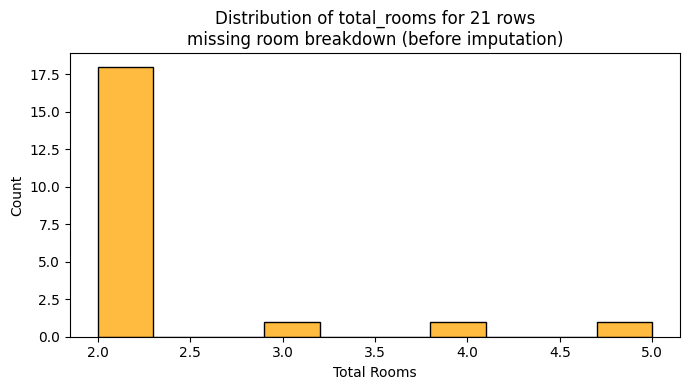

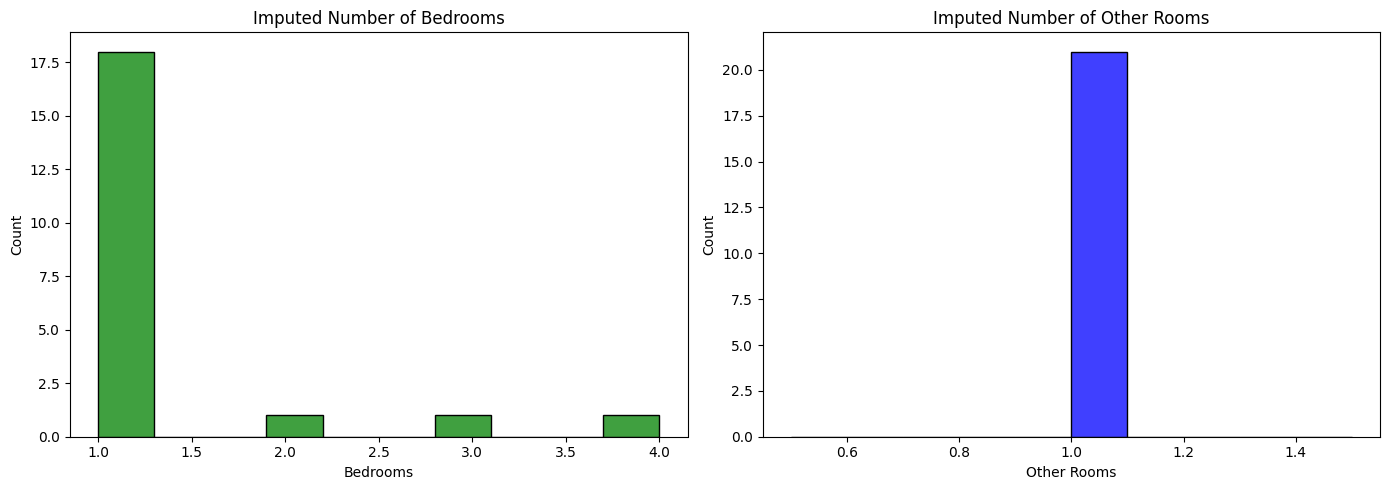

In [232]:
import matplotlib.pyplot as plt
import seaborn as sns

# STEP 1: Identify missing room breakdowns
missing_test_mask = (
    (test['total_rooms'].notnull()) &
    (test['num_bedrooms'] == 0) &
    (test['num_other_rooms'] == 0)
)
num_missing_rows = missing_test_mask.sum()

# STEP 2: Plot total_rooms distribution before imputation
plt.figure(figsize=(7, 4))
sns.histplot(test.loc[missing_test_mask, 'total_rooms'], bins=10, kde=False, color='orange')
plt.title(f'Distribution of total_rooms for {num_missing_rows} rows\nmissing room breakdown (before imputation)')
plt.xlabel('Total Rooms')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# STEP 3: Apply imputation (1 other room, rest as bedrooms)
test.loc[missing_test_mask, 'num_other_rooms'] = 1
test.loc[missing_test_mask, 'num_bedrooms'] = test.loc[missing_test_mask, 'total_rooms'] - 1

# STEP 4: Plot imputed distributions
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(test.loc[missing_test_mask, 'num_bedrooms'], bins=10, ax=axs[0], color='green')
axs[0].set_title('Imputed Number of Bedrooms')
axs[0].set_xlabel('Bedrooms')

sns.histplot(test.loc[missing_test_mask, 'num_other_rooms'], bins=10, ax=axs[1], color='blue')
axs[1].set_title('Imputed Number of Other Rooms')
axs[1].set_xlabel('Other Rooms')

plt.tight_layout()
plt.show()


In [233]:
train['num_bedrooms'].unique()

array([2., 0., 4., 3., 1., 5., 6.])

In [234]:
train['num_other_rooms'].unique()

array([2., 1., 0., 4., 3.])

In [235]:
test['num_other_rooms'].unique()

array([1., 2., 0., 3., 9., 4., 5., 8.])

In [236]:
test[(test['num_other_rooms'] == 8) | (test['num_other_rooms'] == 9)][['description', 'num_other_rooms']]

,description,num_other_rooms
390,"5+ (5 bedrooms, 9 others), 3+ bathrooms, kitch...",9.0
2586,"5+ (4 bedrooms, 8 others), 3 bathrooms, kitche...",8.0


In [237]:
test['num_bedrooms'].unique()

array([ 1.,  3.,  2., 31.,  4.,  0.,  5.])

In [238]:
# Find rows where the sum of bedrooms and other rooms exceeds the parsed total_rooms
room_sum_exceeds_total = (
    (test['num_bedrooms'] + test['num_other_rooms'] > test['total_rooms']) &
    (test['total_rooms'].notnull())
)

# Display those rows for inspection
invalid_totals_df = test[room_sum_exceeds_total][['description', 'total_rooms', 'num_bedrooms', 'num_other_rooms']]
print(invalid_totals_df)


Empty DataFrame
Columns: [description, total_rooms, num_bedrooms, num_other_rooms]
Index: []


In [239]:
train.columns

Index(['w', 'y', 'square_meters', 'contract_type', 'availability',
       'description', 'other_features', 'conditions', 'floor', 'elevator',
       'energy_efficiency_class', 'condominium_fees', 'zone',
       'availability_date', 'is_available', 'availability_encoded',
       'energy_class_num', 'energy_efficiency_class_encoded',
       'conditions_encoded', 'floor_num', 'elevator_sign', 'floor_effect',
       'total_rooms', 'num_bedrooms', 'num_other_rooms', 'num_bathrooms',
       'kitchen_open', 'kitchen_diner', 'kitchen_nook', 'kitchen_semi',
       'kitchenette', 'kitchen_none', 'suitable_disabled'],
      dtype='object')

In [240]:
# Filter train and test separately where num_bedrooms + num_other_rooms > 5
train_5plus = train[(train['num_bedrooms'] + train['num_other_rooms']) > 5][
    ['description', 'total_rooms', 'num_bedrooms', 'num_other_rooms']
].copy()
train_5plus['source'] = 'train'

test_5plus = test[(test['num_bedrooms'] + test['num_other_rooms']) > 5][
    ['description', 'total_rooms', 'num_bedrooms', 'num_other_rooms']
].copy()
test_5plus['source'] = 'test'

# Display them separately
print("🔹 Train Set (Bedrooms + Other Rooms >= 5):")
print(train_5plus.reset_index(drop=True).to_string(index=False))

print("\n🔸 Test Set (Bedrooms + Other Rooms >= 5):")
print(test_5plus.reset_index(drop=True).to_string(index=False))


🔹 Train Set (Bedrooms + Other Rooms >= 5):
                                                   description  total_rooms  num_bedrooms  num_other_rooms source
         5+ (4 bedrooms, 2 others), 2 bathrooms, kitchen diner          NaN           4.0              2.0  train
          5+ (2 bedrooms, 4 others), 1 bathroom, kitchen diner          NaN           2.0              4.0  train
         5+ (4 bedrooms, 2 others), 3 bathrooms, kitchen diner          NaN           4.0              2.0  train
 5+ (5 bedrooms, 1 other), 2 bathrooms, semi-habitable kitchen          NaN           5.0              1.0  train
         5+ (3 bedrooms, 3 others), 3 bathrooms, kitchen diner          NaN           3.0              3.0  train
                        5+ (3 bedrooms, 3 others), 3 bathrooms          NaN           3.0              3.0  train
                        6 bedrooms, 3 bathrooms, kitchen diner          NaN           6.0              0.0  train
         5+ (4 bedrooms, 2 others), 2 bathroo

In [241]:
# Impute total_rooms where it's NaN using num_bedrooms + num_other_rooms
train.loc[
    (train['total_rooms'].isna()) & ((train['num_bedrooms'] + train['num_other_rooms']) > 5),
    'total_rooms'
] = train['num_bedrooms'] + train['num_other_rooms']

test.loc[
    (test['total_rooms'].isna()) & ((test['num_bedrooms'] + test['num_other_rooms']) > 5),
    'total_rooms'
] = test['num_bedrooms'] + test['num_other_rooms']


In [242]:
# Filter train and test separately where num_bedrooms + num_other_rooms > 5
train_5plus = train[(train['num_bedrooms'] + train['num_other_rooms']) > 5][
    ['description', 'total_rooms', 'num_bedrooms', 'num_other_rooms']
].copy()
train_5plus['source'] = 'train'

test_5plus = test[(test['num_bedrooms'] + test['num_other_rooms']) > 5][
    ['description', 'total_rooms', 'num_bedrooms', 'num_other_rooms']
].copy()
test_5plus['source'] = 'test'

# Display them separately
print("🔹 Train Set (Bedrooms + Other Rooms >= 5):")
print(train_5plus.reset_index(drop=True).to_string(index=False))

print("\n🔸 Test Set (Bedrooms + Other Rooms >= 5):")
print(test_5plus.reset_index(drop=True).to_string(index=False))


🔹 Train Set (Bedrooms + Other Rooms >= 5):
                                                   description  total_rooms  num_bedrooms  num_other_rooms source
         5+ (4 bedrooms, 2 others), 2 bathrooms, kitchen diner          6.0           4.0              2.0  train
          5+ (2 bedrooms, 4 others), 1 bathroom, kitchen diner          6.0           2.0              4.0  train
         5+ (4 bedrooms, 2 others), 3 bathrooms, kitchen diner          6.0           4.0              2.0  train
 5+ (5 bedrooms, 1 other), 2 bathrooms, semi-habitable kitchen          6.0           5.0              1.0  train
         5+ (3 bedrooms, 3 others), 3 bathrooms, kitchen diner          6.0           3.0              3.0  train
                        5+ (3 bedrooms, 3 others), 3 bathrooms          6.0           3.0              3.0  train
                        6 bedrooms, 3 bathrooms, kitchen diner          6.0           6.0              0.0  train
         5+ (4 bedrooms, 2 others), 2 bathroo

In [243]:
# Impute total_rooms where it's NaN using num_bedrooms + num_other_rooms
train.loc[
    (train['total_rooms'].isna()) & ((train['num_bedrooms'] + train['num_other_rooms']) > 5),
    'total_rooms'
] = train['num_bedrooms'] + train['num_other_rooms']

test.loc[
    (test['total_rooms'].isna()) & ((test['num_bedrooms'] + test['num_other_rooms']) > 5),
    'total_rooms'
] = test['num_bedrooms'] + test['num_other_rooms']


In [244]:
# Filter train and test separately where num_bedrooms + num_other_rooms > 5
train_5plus = train[(train['num_bedrooms'] + train['num_other_rooms']) > 5][
    ['description', 'total_rooms', 'num_bedrooms', 'num_other_rooms']
].copy()
train_5plus['source'] = 'train'

test_5plus = test[(test['num_bedrooms'] + test['num_other_rooms']) > 5][
    ['description', 'total_rooms', 'num_bedrooms', 'num_other_rooms']
].copy()
test_5plus['source'] = 'test'

# Display them separately
print("🔹 Train Set (Bedrooms + Other Rooms >= 5):")
print(train_5plus.reset_index(drop=True).to_string(index=False))

print("\n🔸 Test Set (Bedrooms + Other Rooms >= 5):")
print(test_5plus.reset_index(drop=True).to_string(index=False))


🔹 Train Set (Bedrooms + Other Rooms >= 5):
                                                   description  total_rooms  num_bedrooms  num_other_rooms source
         5+ (4 bedrooms, 2 others), 2 bathrooms, kitchen diner          6.0           4.0              2.0  train
          5+ (2 bedrooms, 4 others), 1 bathroom, kitchen diner          6.0           2.0              4.0  train
         5+ (4 bedrooms, 2 others), 3 bathrooms, kitchen diner          6.0           4.0              2.0  train
 5+ (5 bedrooms, 1 other), 2 bathrooms, semi-habitable kitchen          6.0           5.0              1.0  train
         5+ (3 bedrooms, 3 others), 3 bathrooms, kitchen diner          6.0           3.0              3.0  train
                        5+ (3 bedrooms, 3 others), 3 bathrooms          6.0           3.0              3.0  train
                        6 bedrooms, 3 bathrooms, kitchen diner          6.0           6.0              0.0  train
         5+ (4 bedrooms, 2 others), 2 bathroo

In [245]:
print("Missing 'total_rooms' in Train:", train['total_rooms'].isnull().sum())
print("Missing 'total_rooms' in Test:", test['total_rooms'].isnull().sum())

Missing 'total_rooms' in Train: 676
Missing 'total_rooms' in Test: 429


In [246]:
print("Missing 'num_bedrooms' in Train:", train['num_bedrooms'].isnull().sum())
print("Missing 'num_bedrooms' in Test:", test['num_bedrooms'].isnull().sum())

Missing 'num_bedrooms' in Train: 0
Missing 'num_bedrooms' in Test: 0


In [247]:
print("Missing 'num_other_rooms' in Train:", train['num_other_rooms'].isnull().sum())
print("Missing 'num_other_rooms' in Test:", test['num_other_rooms'].isnull().sum())

Missing 'num_other_rooms' in Train: 0
Missing 'num_other_rooms' in Test: 0


In [248]:
# Get rows where 'total_rooms' is missing in train
missing_total_rooms_train = train[train['total_rooms'].isnull()]
print("Rows in Train with Missing 'total_rooms':")
print(missing_total_rooms_train[['description', 'total_rooms', 'num_bedrooms', 'num_other_rooms']].to_string())

print("\nDescription of Missing 'total_rooms' in Train:")
print(missing_total_rooms_train['total_rooms'].describe(include='all'))


# Get rows where 'total_rooms' is missing in test
missing_total_rooms_test = test[test['total_rooms'].isnull()]
print("\nRows in Test with Missing 'total_rooms':")
print(missing_total_rooms_test[['description', 'total_rooms', 'num_bedrooms', 'num_other_rooms']].to_string())

print("\nDescription of Missing 'total_rooms' in Test:")
print(missing_total_rooms_test['total_rooms'].describe(include='all'))

Rows in Train with Missing 'total_rooms':
                                                           description  total_rooms  num_bedrooms  num_other_rooms
3                                     1 room, 1 bathroom, kitchen nook          NaN           0.0              0.0
11                                 1 bedroom, 1 bathroom, open kitchen          NaN           1.0              0.0
15                      2 bedrooms, 1 bathroom, semi-habitable kitchen          NaN           2.0              0.0
18                                    1 room, 1 bathroom, open kitchen          NaN           0.0              0.0
26                              5 bedrooms, 2 bathrooms, kitchen diner          NaN           5.0              0.0
28                                1 bedroom, 1 bathroom, kitchen diner          NaN           1.0              0.0
37                                 1 bedroom, 1 bathroom, kitchen nook          NaN           1.0              0.0
42                                    

In [249]:
# Fix 1: If "1 room" is in description and both bedroom/other are 0 → assign 1 bedroom
for df in [train, test]:
    mask_room_only = (
        df['description'].str.lower().str.contains(r'\b1 room\b', na=False) &
        (df['num_bedrooms'] == 0) &
        (df['num_other_rooms'] == 0)
    )
    df.loc[mask_room_only, 'num_bedrooms'] = 1

# Fix 2: Impute missing total_rooms as the sum of bedrooms + other rooms
for df in [train, test]:
    mask_missing_total = df['total_rooms'].isna()
    df.loc[mask_missing_total, 'total_rooms'] = (
        df.loc[mask_missing_total, 'num_bedrooms'] + df.loc[mask_missing_total, 'num_other_rooms']
    )


In [250]:
# Get rows where 'total_rooms' is missing in train
missing_total_rooms_train = train[train['total_rooms'].isnull()]
print("Rows in Train with Missing 'total_rooms':")
print(missing_total_rooms_train[['description', 'total_rooms', 'num_bedrooms', 'num_other_rooms']].to_string())

print("\nDescription of Missing 'total_rooms' in Train:")
print(missing_total_rooms_train['total_rooms'].describe(include='all'))


# Get rows where 'total_rooms' is missing in test
missing_total_rooms_test = test[test['total_rooms'].isnull()]
print("\nRows in Test with Missing 'total_rooms':")
print(missing_total_rooms_test[['description', 'total_rooms', 'num_bedrooms', 'num_other_rooms']].to_string())

print("\nDescription of Missing 'total_rooms' in Test:")
print(missing_total_rooms_test['total_rooms'].describe(include='all'))

Rows in Train with Missing 'total_rooms':
Empty DataFrame
Columns: [description, total_rooms, num_bedrooms, num_other_rooms]
Index: []

Description of Missing 'total_rooms' in Train:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: total_rooms, dtype: float64

Rows in Test with Missing 'total_rooms':
Empty DataFrame
Columns: [description, total_rooms, num_bedrooms, num_other_rooms]
Index: []

Description of Missing 'total_rooms' in Test:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: total_rooms, dtype: float64


In [251]:
print("Missing 'total_rooms' in Train:", train['total_rooms'].isnull().sum())
print("Missing 'total_rooms' in Test:", test['total_rooms'].isnull().sum())

Missing 'total_rooms' in Train: 0
Missing 'total_rooms' in Test: 0


In [252]:
# Check for inconsistencies: total_rooms not equal to num_bedrooms + num_other_rooms
train_inconsistent = train[
    train['total_rooms'] != (train['num_bedrooms'] + train['num_other_rooms'])
][['description', 'total_rooms', 'num_bedrooms', 'num_other_rooms']]

test_inconsistent = test[
    test['total_rooms'] != (test['num_bedrooms'] + test['num_other_rooms'])
][['description', 'total_rooms', 'num_bedrooms', 'num_other_rooms']]

# Display result
print("Inconsistent rows in TRAIN:")
print(train_inconsistent)

print("\nInconsistent rows in TEST:")
print(test_inconsistent)


Inconsistent rows in TRAIN:
                             description  total_rooms  num_bedrooms  \
13                   3 rooms, 1 bathroom          3.0           0.0   
121                  2 rooms, 1 bathroom          2.0           0.0   
134    2 rooms, 1 bathroom, kitchen nook          2.0           0.0   
284   3 rooms, 2 bathrooms, kitchen nook          3.0           0.0   
371                  2 rooms, 1 bathroom          2.0           0.0   
377                  2 rooms, 1 bathroom          2.0           0.0   
578                              2 rooms          2.0           0.0   
793                              3 rooms          3.0           0.0   
811                  2 rooms, 1 bathroom          2.0           0.0   
952                  3 rooms, 1 bathroom          3.0           0.0   
960                              2 rooms          2.0           0.0   
1103                 3 rooms, 1 bathroom          3.0           0.0   
1241    2 rooms, 1 bathroom, kitchenette         

In [253]:
# Define the mask to select the rows that will be targeted for imputation
# This mask represents the rows *before* the imputation that have the issue
mask_to_impute_train = (
    train['total_rooms'].notnull() &  # total_rooms is known
    (train['total_rooms'] > 0) &      # And total_rooms is more than zero
    (train['num_bedrooms'] == 0) &    # Bedrooms is 0
    (train['num_other_rooms'] == 0)   # Other rooms is 0
)

mask_to_impute_test = (
    test['total_rooms'].notnull() &   # total_rooms is known
    (test['total_rooms'] > 0) &       # And total_rooms is more than zero
    (test['num_bedrooms'] == 0) &     # Bedrooms is 0
    (test['num_other_rooms'] == 0)    # Other rooms is 0
)

print("Rows in Train that will be targeted for imputation (before fix):")
# Display the rows that fit this pattern
display(train[mask_to_impute_train][['description', 'total_rooms', 'num_bedrooms', 'num_other_rooms']].head())


print("\nRows in Test that will be targeted for imputation (before fix):")
# Display the rows that fit this pattern
display(test[mask_to_impute_test][['description', 'total_rooms', 'num_bedrooms', 'num_other_rooms']].head())


print("\nCounts of rows that will be targeted for imputation (before fix):")
print(f"Train: {mask_to_impute_train.sum()}")
print(f"Test: {mask_to_impute_test.sum()}")

Rows in Train that will be targeted for imputation (before fix):


,description,total_rooms,num_bedrooms,num_other_rooms
13,"3 rooms, 1 bathroom",3.0,0.0,0.0
121,"2 rooms, 1 bathroom",2.0,0.0,0.0
134,"2 rooms, 1 bathroom, kitchen nook",2.0,0.0,0.0
284,"3 rooms, 2 bathrooms, kitchen nook",3.0,0.0,0.0
371,"2 rooms, 1 bathroom",2.0,0.0,0.0



Rows in Test that will be targeted for imputation (before fix):


,description,total_rooms,num_bedrooms,num_other_rooms



Counts of rows that will be targeted for imputation (before fix):
Train: 36
Test: 0


In [254]:
# Define the mask to select the rows that will be targeted for imputation
# This mask represents the rows *before* the imputation that have the issue
mask_to_impute_train = (
    train['total_rooms'].notnull() &  # total_rooms is known
    (train['total_rooms'] > 0) &      # And total_rooms is more than zero
    (train['num_bedrooms'] == 0) &    # Bedrooms is 0
    (train['num_other_rooms'] == 0)   # Other rooms is 0
)

mask_to_impute_test = (
    test['total_rooms'].notnull() &   # total_rooms is known
    (test['total_rooms'] > 0) &       # And total_rooms is more than zero
    (test['num_bedrooms'] == 0) &     # Bedrooms is 0
    (test['num_other_rooms'] == 0)    # Other rooms is 0
)

print("Applying imputation to the following number of rows:")
print(f"Train: {mask_to_impute_train.sum()}")
print(f"Test: {mask_to_impute_test.sum()}")

# Apply the imputation ONLY to the rows identified by the masks
# Imputation strategy: 1 other room, rest are bedrooms

# For Train:
train.loc[mask_to_impute_train, 'num_other_rooms'] = 1
train.loc[mask_to_impute_train, 'num_bedrooms'] = train.loc[mask_to_impute_train, 'total_rooms'] - 1

# For Test: (This won't change anything since the count is 0, but it's good practice)
test.loc[mask_to_impute_test, 'num_other_rooms'] = 1
test.loc[mask_to_impute_test, 'num_bedrooms'] = test.loc[mask_to_impute_test, 'total_rooms'] - 1

print("\nImputation applied.")

Applying imputation to the following number of rows:
Train: 36
Test: 0

Imputation applied.


## 6 - Other Features

In [255]:
train['other_features'].unique()

array(['kitchen | balcony | terrace | furnished | cellar | shared garden | window frames in double glass / pvcexposure south',
       'electric gate | optic fiber | alarm system | closet | balcony | terrace | full day concierge | centralized tv system | furnished | cellar | shared garden | window frames in double glass / pvcdouble exposure',
       'internal exposure | balcony | full day concierge | cellar | shared garden',
       ...,
       'video entryphone | single tv system | furnished | double exposure',
       'optic fiber | alarm system | internal exposure | closet | full day concierge | tv system with satellite dish | furnished | window frames in double glass / pvc',
       'electric gate | optic fiber | security door | balcony | centralized tv system | furnished | window frames in glass / metal | double exposure'],
      dtype=object)

In [256]:
train['other_features'].nunique()

3081

c:\Users\utaka\anaconda3\envs\mlops\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Total unique features: 145

Top 20 features:
                                 feature  count
32                             furnished   4822
8                  centralized tv system   4681
48                         security door   4622
4                                balcony   3312
30                    full day concierge   2672
129                          optic fiber   2577
58                      video entryphone   2122
9                                 closet   2113
115                        electric gate   1956
39                           optic fiber   1893
27                     external exposure   1862
50                         shared garden   1730
34                    half-day concierge   1668
6                                 cellar   1390
10                       double exposure   1320
35                     internal exposure   1137
61   window frames in double glass / pvc   1061
56                               terrace   1000
78        window frames in glass / metal   

<Figure size 1200x600 with 0 Axes>

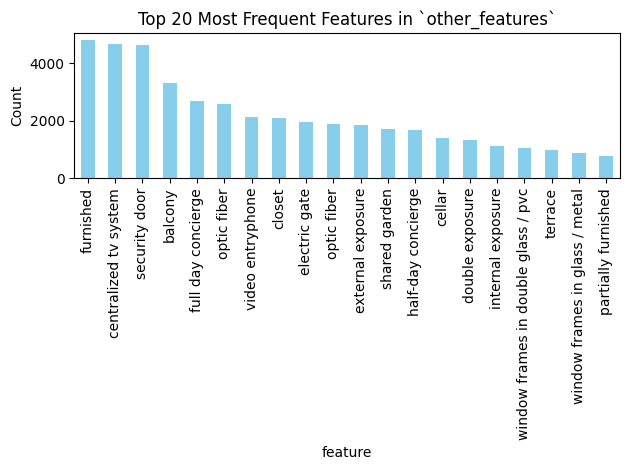

In [257]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Combine for analysis
combined_features = pd.concat([train['other_features'], test['other_features']], axis=0).fillna('')

# Tokenize using '|' separator
vectorizer = CountVectorizer(tokenizer=lambda x: x.split('|'), binary=True)
X = vectorizer.fit_transform(combined_features)

# Extract feature names and frequencies
feature_names = [f.strip() for f in vectorizer.get_feature_names_out()]
feature_counts = X.sum(axis=0).A1  # convert to 1D array
features_df = pd.DataFrame({'feature': feature_names, 'count': feature_counts})
features_df.sort_values(by='count', ascending=False, inplace=True)

# Print number of unique features
print(f"Total unique features: {features_df.shape[0]}")

# Show top 20 most frequent features
print("\nTop 20 features:")
print(features_df.head(20))

# Plot
plt.figure(figsize=(12, 6))
features_df.head(20).plot.bar(x='feature', y='count', legend=False, color='skyblue')
plt.title('Top 20 Most Frequent Features in `other_features`')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


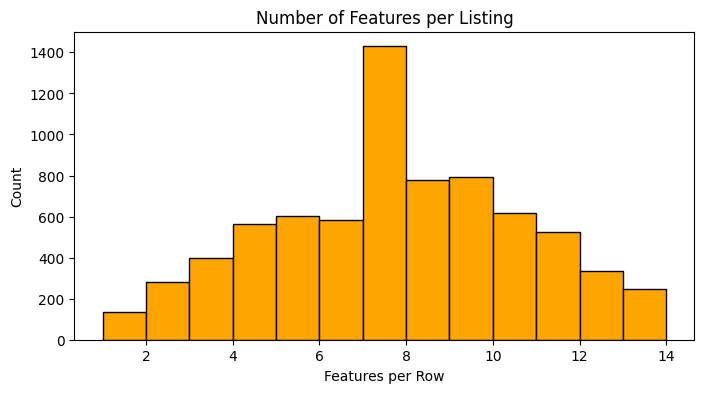

In [258]:
# How many features are mentioned per listing?
num_features_per_row = (X > 0).sum(axis=1).A1
plt.figure(figsize=(8, 4))
plt.hist(num_features_per_row, bins=range(1, 15), color='orange', edgecolor='black')
plt.title('Number of Features per Listing')
plt.xlabel('Features per Row')
plt.ylabel('Count')
plt.show()


In [259]:
# Show all features, not just top 20
print("\nAll unique features and their counts:")
# Use to_string() to print the entire DataFrame without truncation
print(features_df.to_string())



All unique features and their counts:
                                                                  feature  count
32                                                              furnished   4822
8                                                   centralized tv system   4681
48                                                          security door   4622
4                                                                 balcony   3312
30                                                     full day concierge   2672
129                                                           optic fiber   2577
58                                                       video entryphone   2122
9                                                                  closet   2113
115                                                         electric gate   1956
39                                                            optic fiber   1893
27                                                      external expos

In [260]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import re

# Step 1: Cleaning function
def clean_token(token):
    token = token.lower().strip()
    token = re.sub(r'\s+', ' ', token)
    return token

# Step 2: Improved tokenizer
def smart_tokenizer(text):
    if pd.isna(text): return []

    tokens = []
    for raw in text.split('|'):
        raw = clean_token(raw)

        # Handle broken "window frames + exposure" tokens
        if 'window frames' in raw and 'exposure' in raw:
            match = re.search(r'(.*?)(exposure[\w\s,/-]*)', raw)
            if match:
                base, exposure = match.groups()
                if base.strip(): tokens.append(base.strip())
                if exposure.strip(): tokens.append(exposure.strip())
            else:
                tokens.append(raw)
        else:
            tokens.append(raw)

    return list(set(tokens))  # remove duplicates

# Step 3: Combine features for inspection only
combined = pd.concat([train['other_features'], test['other_features']], axis=0).fillna('')
vectorizer = CountVectorizer(tokenizer=smart_tokenizer, binary=True)
X_combined = vectorizer.fit_transform(combined)

# Step 4: Inspect the cleaned feature names and frequencies
feature_names = [clean_token(f) for f in vectorizer.get_feature_names_out()]
token_counts = X_combined.sum(axis=0).A1
features_df = pd.DataFrame({'feature': feature_names, 'count': token_counts})
features_df = features_df.sort_values(by='count', ascending=False).reset_index(drop=True)

# Step 5: Print summary
print(f"✅ Extracted {len(feature_names)} cleaned binary features.\n")
print("🔝 Features:")
print(features_df.to_string(index=False))


✅ Extracted 62 cleaned binary features.

🔝 Features:
                                  feature  count
                                furnished   5491
                            security door   5339
                    centralized tv system   4702
                              optic fiber   4470
                                  balcony   3638
                       full day concierge   2795
                         video entryphone   2383
                                   closet   2145
                            electric gate   2037
                        external exposure   1937
                            shared garden   1921
                       half-day concierge   1671
                                   cellar   1526
     window frames in double glass / wood   1324
                          double exposure   1321
                        internal exposure   1216
      window frames in double glass / pvc   1194
                                  terrace   1042
           windo

c:\Users\utaka\anaconda3\envs\mlops\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [261]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import re

# Step 1: Cleaning function
def clean_token(token):
    token = token.lower().strip()
    token = re.sub(r'\s+', ' ', token)
    return token

# Step 2: Smart tokenizer with directional exposure parsing
def smart_tokenizer(text):
    if pd.isna(text): return []

    tokens = []
    for raw in text.split('|'):
        raw = clean_token(raw)

        # Case 1: Malformed "window frames in ... exposure"
        if 'window frames' in raw and 'exposure' in raw:
            match = re.search(r'(.*?)(exposure[\w\s,/-]*)', raw)
            if match:
                base, exposure = match.groups()
                if base.strip():
                    tokens.append(clean_token(base))
                # Extract exposure directions from suffix
                directions = re.findall(r'north|south|east|west', exposure)
                for dir in directions:
                    tokens.append(f"exposure_{dir}")
            else:
                tokens.append(raw)

        # Case 2: Normal exposure strings like "exposure south, east"
        elif 'exposure' in raw:
            directions = re.findall(r'north|south|east|west', raw)
            for dir in directions:
                tokens.append(f"exposure_{dir}")

        else:
            tokens.append(raw)

    return list(set(tokens))  # remove duplicates

# Step 3: Combine features for inspection only
combined = pd.concat([train['other_features'], test['other_features']], axis=0).fillna('')
vectorizer = CountVectorizer(tokenizer=smart_tokenizer, binary=True)
X_combined = vectorizer.fit_transform(combined)

# Step 4: Inspect the cleaned feature names and frequencies
feature_names = [clean_token(f) for f in vectorizer.get_feature_names_out()]
token_counts = X_combined.sum(axis=0).A1
features_df = pd.DataFrame({'feature': feature_names, 'count': token_counts})
features_df = features_df.sort_values(by='count', ascending=False).reset_index(drop=True)

# Step 5: Print summary
print(f"✅ Extracted {len(feature_names)} cleaned binary features.\n")
print("🔝 Features:")
print(features_df.to_string(index=False))


c:\Users\utaka\anaconda3\envs\mlops\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


✅ Extracted 47 cleaned binary features.

🔝 Features:
                                  feature  count
                                furnished   5491
                            security door   5339
                    centralized tv system   4702
                              optic fiber   4470
                                  balcony   3638
                       full day concierge   2795
                         video entryphone   2383
                                   closet   2145
                            electric gate   2037
                            shared garden   1921
                       half-day concierge   1671
                                   cellar   1526
     window frames in double glass / wood   1324
      window frames in double glass / pvc   1194
                                  terrace   1042
           window frames in glass / metal    938
                      partially furnished    849
                             alarm system    832
window frames in

In [262]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import re

# Step 1: Cleaning function
def clean_token(token):
    token = token.lower().strip()
    token = re.sub(r'\s+', ' ', token)
    return token

# Step 2: Final tokenizer with aggressive window + exposure grouping
def smart_tokenizer(text):
    if pd.isna(text): return []

    tokens = []
    for raw in text.split('|'):
        raw = clean_token(raw)

        # 🌞 Exposure directions (independent or inside other strings)
        if 'exposure' in raw:
            directions = re.findall(r'north|south|east|west', raw)
            for dir in directions:
                tokens.append(f"exposure_{dir}")

        # 🪟 Window frame grouping
        if 'window frames' in raw:
            if 'double glass' in raw:
                tokens.append('window_double_glass')
            if 'triple glass' in raw:
                tokens.append('window_triple_glass')
            if 'pvc' in raw:
                tokens.append('window_pvc')
            if 'wood' in raw:
                tokens.append('window_wood')
            if 'metal' in raw:
                tokens.append('window_metal')

        # 🎯 Add general cleaned tokens (excluding raw window frame/exposure strings)
        if 'window frames' not in raw and 'exposure' not in raw:
            tokens.append(raw)

    return list(set(tokens))  # remove duplicates

# Step 3: Apply tokenizer to train + test combined
combined = pd.concat([train['other_features'], test['other_features']], axis=0).fillna('')
vectorizer = CountVectorizer(tokenizer=smart_tokenizer, binary=True)
X_combined = vectorizer.fit_transform(combined)

# Step 4: Summarize and display feature frequencies
feature_names = [clean_token(f) for f in vectorizer.get_feature_names_out()]
token_counts = X_combined.sum(axis=0).A1
features_df = pd.DataFrame({'feature': feature_names, 'count': token_counts})
features_df = features_df.sort_values(by='count', ascending=False).reset_index(drop=True)

# Step 5: Print summary
print(f"✅ Extracted {len(feature_names)} compact binary features.\n")
print("🔝 Features:")
print(features_df.to_string(index=False))


c:\Users\utaka\anaconda3\envs\mlops\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


✅ Extracted 40 compact binary features.

🔝 Features:
                      feature  count
                    furnished   5491
                security door   5339
        centralized tv system   4702
                  optic fiber   4470
          window_double_glass   3944
                      balcony   3638
           full day concierge   2795
             video entryphone   2383
                   window_pvc   2226
                       closet   2145
                electric gate   2037
                shared garden   1921
                  window_wood   1909
                 window_metal   1710
           half-day concierge   1671
                       cellar   1526
                      terrace   1042
          partially furnished    849
                 alarm system    832
                      kitchen    662
       only kitchen furnished    386
             single tv system    347
          window_triple_glass    278
               exposure_south    251
                exposu

In [263]:
# Step 1: Filter features that appear in at least 15 listings
min_count = 15
final_features = features_df[features_df['count'] >= min_count]['feature'].tolist()
print(f"✅ Retained {len(final_features)} features with count ≥ {min_count}")

# Step 2: Recreate DataFrames from X_combined using final features
# Rebuild full feature matrix DataFrame
X_full_df = pd.DataFrame(X_combined.toarray(), columns=feature_names)

# Step 3: Split back into aligned train/test
X_train_df = X_full_df.iloc[:len(train)][final_features].set_index(train.index)
X_test_df = X_full_df.iloc[len(train):][final_features].set_index(test.index)

# Step 4: Safely assign to original datasets
train = pd.concat([train, X_train_df], axis=1)
test = pd.concat([test, X_test_df], axis=1)

print("✅ Final filtered binary features successfully and safely added to train and test.")


✅ Retained 37 features with count ≥ 15
✅ Final filtered binary features successfully and safely added to train and test.


In [264]:
train.head()

,w,y,square_meters,contract_type,availability,description,other_features,conditions,floor,elevator,...,reception,exposure_north,attic,fireplace,tv system with satellite dish,hydromassage,pool,tavern,private and shared garden,tennis court
0,1,3000,110,rent,unknown,"4 (2 bedrooms, 2 others), 1 bathroom - one or ...",kitchen | balcony | terrace | furnished | cell...,excellent,1,yes,...,0,0,0,0,0,0,0,0,0,0
1,1,2200,111,rent,available,"3 (2 bedrooms, 1 other), 1 bathroom, kitchen d...",electric gate | optic fiber | alarm system | c...,excellent,6,yes,...,0,0,0,0,0,0,0,0,0,0
2,1,2500,85,rent | 4+4,unknown,"3 (2 bedrooms, 1 other), 2 bathrooms, open kit...",internal exposure | balcony | full day concier...,good condition,4,yes,...,0,0,0,0,0,0,0,0,0,0
3,1,1250,40,rent,available,"1 room, 1 bathroom, kitchen nook",optic fiber | security door | internal exposur...,excellent,2,yes,...,0,0,0,0,0,0,0,0,0,0
4,1,4200,170,rent | open,available,"4 (2 bedrooms, 2 others), 3 bathrooms, kitchen...",fireplace | optic fiber | security door | balc...,excellent,4,yes,...,0,0,0,1,0,0,0,0,0,0


In [265]:
test.head()

,square_meters,contract_type,availability,description,other_features,conditions,floor,elevator,energy_efficiency_class,condominium_fees,...,reception,exposure_north,attic,fireplace,tv system with satellite dish,hydromassage,pool,tavern,private and shared garden,tennis court
0,58,rent | open,available,"2 (1 bedroom, 1 other), 1 bathroom, kitchen nook",electric gate | optic fiber | security door | ...,excellent,1,yes,g,140.0,...,0,0,0,0,0,0,0,0,0,0
1,55,rent | 4+4,available,"2 (1 bedroom, 1 other), 1 bathroom, kitchen nook",optic fiber | security door | internal exposur...,good condition,Mezzanine,no,g,80.0,...,0,0,0,0,0,0,0,0,0,0
2,68,rent | 4+4,available,"2 (1 bedroom, 1 other), 1 bathroom, kitchen diner",video entryphone | full day concierge | furnished,good condition,4,yes,g,200.0,...,0,0,0,0,0,0,0,0,0,0
3,50,rent | transitory,available,"2 (1 bedroom, 1 other), 1 bathroom, open kitchen",optic fiber | security door | balcony | terrac...,excellent,5,yes,f,150.0,...,0,0,0,0,0,0,0,0,0,0
4,105,rent | 4+4,available,"2 (1 bedroom, 1 other), 2 bathrooms, kitchen nook",hydromassage | attic | video entryphone | alar...,excellent,5,yes,d,220.0,...,0,0,1,0,1,1,0,0,0,0


## 7 - Condominimum

In [266]:
train['condominium_fees'].isnull().sum()

197

In [267]:
test['condominium_fees'].isnull().sum()

124

In [271]:
# Group medians by elevator_sign, full day concierge, centralized tv system, and shared garden
group_medians = train.groupby(['elevator_sign', 'full day concierge', 'centralized tv system', 'shared garden'])['condominium_fees'].median().reset_index()

# Group counts for significance
group_counts = train.groupby(['elevator_sign', 'full day concierge', 'centralized tv system', 'shared garden']).size().reset_index(name='count')

# Merge
group_summary = pd.merge(group_medians, group_counts, on=['elevator_sign', 'full day concierge', 'centralized tv system', 'shared garden'])

# Correlation (numeric only)
# Include the new binary features and the encoded zone for a broader view
correlations = train[['condominium_fees', 'elevator_sign', 'full day concierge', 'centralized tv system', 'shared garden']].copy()
cor_matrix = correlations.corr(numeric_only=True)['condominium_fees'][1:] # Exclude self-correlation

print("📊 Group Median Summary by Features")
display(group_summary)

print("\n📈 Correlation with Condominium Fees:")
print(cor_matrix.round(4))

📊 Group Median Summary by Features


,elevator_sign,full day concierge,centralized tv system,shared garden,condominium_fees,count
0,-1,0,0,0,100.0,266
1,-1,0,0,1,105.0,71
2,-1,0,1,0,0.0,729
3,-1,0,1,1,135.0,97
4,-1,1,0,0,118.5,54
5,-1,1,0,1,200.0,15
6,-1,1,1,0,136.0,47
7,-1,1,1,1,136.0,23
8,1,0,0,0,150.0,527
9,1,0,0,1,190.0,193



📈 Correlation with Condominium Fees:
elevator_sign            0.3249
full day concierge       0.2705
centralized tv system   -0.0327
shared garden            0.1060
Name: condominium_fees, dtype: float64


In [272]:
# Group medians by elevator_sign, full day concierge, and shared garden
group_medians = train.groupby(['elevator_sign', 'full day concierge', 'shared garden'])['condominium_fees'].median().reset_index()

# Group counts for significance
group_counts = train.groupby(['elevator_sign', 'full day concierge', 'shared garden']).size().reset_index(name='count')

# Merge
group_summary = pd.merge(group_medians, group_counts, on=['elevator_sign', 'full day concierge', 'shared garden'])

# Correlation (numeric only)
# Include the remaining binary features and the encoded zone for a broader view
correlations = train[['condominium_fees', 'elevator_sign', 'full day concierge', 'shared garden']].copy()
cor_matrix = correlations.corr(numeric_only=True)['condominium_fees'][1:] # Exclude self-correlation

print("📊 Group Median Summary by Features")
display(group_summary)

print("\n📈 Correlation with Condominium Fees:")
print(cor_matrix.round(4))

📊 Group Median Summary by Features


,elevator_sign,full day concierge,shared garden,condominium_fees,count
0,-1,0,0,0.0,995
1,-1,0,1,120.0,168
2,-1,1,0,123.0,101
3,-1,1,1,150.0,38
4,1,0,0,167.0,1168
5,1,0,1,200.0,488
6,1,1,0,225.0,988
7,1,1,1,220.0,549



📈 Correlation with Condominium Fees:
elevator_sign         0.3249
full day concierge    0.2705
shared garden         0.1060
Name: condominium_fees, dtype: float64


In [273]:
# Step 3: Define imputation function
def impute_condo_fees(row):
    if pd.isna(row['condominium_fees']):
        key = (row['elevator_sign'], row['full day concierge'], row['shared garden'])
        return group_medians.get(key, np.nan)
    return row['condominium_fees']

# Step 4: Apply imputation
train['condominium_fees'] = train.apply(impute_condo_fees, axis=1)
test['condominium_fees'] = test.apply(impute_condo_fees, axis=1)

# Step 5: Fallback to global median (no chained assignment)
overall_median = train['condominium_fees'].median()
train['condominium_fees'] = train['condominium_fees'].fillna(overall_median)
test['condominium_fees'] = test['condominium_fees'].fillna(overall_median)

In [274]:
train['condominium_fees'].isnull().sum()

0

In [275]:
test['condominium_fees'].isnull().sum()

0

## 8 - Zone

In [276]:
train['zone'].nunique()

132

In [277]:
# 1. Compute average rent (y) per zone from train
zone_target_mean = train.groupby('zone')['y'].mean()

# 2. Map it back to the train and test sets
train['zone_encoded'] = train['zone'].map(zone_target_mean)
test['zone_encoded'] = test['zone'].map(zone_target_mean)


In [278]:
train[['zone_encoded', 'y']].corr()


,zone_encoded,y
zone_encoded,1.000000,0.596901
y,0.596901,1.000000


In [279]:
# Get unique zones and calculate median rent (y) for each zone in the training data
zone_median_rent = train.groupby('zone')['y'].median().reset_index()
zone_median_rent.columns = ['zone', 'median_rent']

# Get counts (observations) per zone in the training data
zone_counts = train.groupby('zone').size().reset_index(name='observations')

# Calculate mean rent (y) per zone in the training data
zone_mean_rent = train.groupby('zone')['y'].mean().reset_index()
zone_mean_rent.columns = ['zone', 'mean_rent']

# Combine the information
zone_summary = pd.merge(zone_median_rent, zone_mean_rent, on='zone')
zone_summary = pd.merge(zone_summary, zone_counts, on='zone')

# Sort by zone for consistency
zone_summary = zone_summary.sort_values(by='zone').reset_index(drop=True)

# Display the combined information for all 132 zones
print("📊 Zone Summary: Median Rent, Mean Rent, and Observations per Zone\n")
# Use to_string() to ensure all rows are displayed
print(zone_summary.to_string())

# Display the total number of zones
print(f"\nTotal unique zones: {len(zone_summary)}")

📊 Zone Summary: Median Rent, Mean Rent, and Observations per Zone

                              zone  median_rent    mean_rent  observations
0                           affori       1100.0  1285.800000            30
1            amendola - buonarroti       1500.0  1997.120000            25
2                  arco della pace       1841.5  2336.269231            26
3                            arena       2500.0  2693.909091            22
4                argonne - corsica       1300.0  1400.969697            33
5                   ascanio sforza       1400.0  1529.032258            31
6                           baggio        900.0   985.555556             9
7                       bande nere       1500.0  1615.600000            25
8                           barona       1450.0  1728.400000            25
9                          bicocca       1200.0  1150.000000            16
10                bignami - ponale       1350.0  1340.769231            13
11                       biscegli

In [280]:
# Step 1: Count observations
zone_counts = train['zone'].value_counts()
threshold = 5

# Step 2: Define frequent zones
frequent_zones = zone_counts[zone_counts >= threshold].index.tolist()

# Step 3: Group rare zones
train['zone_grouped'] = train['zone'].apply(lambda z: z if z in frequent_zones else 'zone_other')
test['zone_grouped'] = test['zone'].apply(lambda z: z if z in frequent_zones else 'zone_other')

# Step 4: Create zone_encoded (average rent by zone_grouped)
zone_avg = train.groupby('zone_grouped')['y'].mean()
train['zone_encoded'] = train['zone_grouped'].map(zone_avg)
test['zone_encoded'] = test['zone_grouped'].map(zone_avg)
test['zone_encoded'] = test['zone_encoded'].fillna(train['y'].mean())

# ✅ Step 5: Create zone_rent_per_sqm = avg(y / sqm) per grouped zone
train['rent_per_sqm'] = train['y'] / train['square_meters']
zone_rpsqm = train.groupby('zone_grouped')['rent_per_sqm'].mean()

train['zone_rent_per_sqm'] = train['zone_grouped'].map(zone_rpsqm)
test['zone_rent_per_sqm'] = test['zone_grouped'].map(zone_rpsqm)
test['zone_rent_per_sqm'] = test['zone_rent_per_sqm'].fillna(train['y'].mean() / train['square_meters'].mean())

# ✅ Step 6: Create estimated_zone_price = rent_per_sqm * sqm
train['estimated_zone_price'] = train['zone_rent_per_sqm'] * train['square_meters']
test['estimated_zone_price'] = test['zone_rent_per_sqm'] * test['square_meters']

In [281]:
train.drop(columns=['rent_per_sqm', 'estimated_zone_price', 'zone_grouped'], inplace=True, errors='ignore')
test.drop(columns=['rent_per_sqm', 'estimated_zone_price', 'zone_grouped'], inplace=True, errors='ignore')

## 9 - Contract Type

In [282]:
train['contract_type'].unique()

array(['rent', 'rent | 4+4', 'rent | open', 'rent | transitory',
       'rent | students (6 - 36 months)', 'rent | 3+2', 'rent | 6+6'],
      dtype=object)

In [283]:
# Aggregate both mean 'y' and count for each 'contract_type'
contract_type_stats = train.groupby('contract_type')['y'].agg(['mean', 'count']).reset_index()

# Rename the columns to be more descriptive
contract_type_stats.columns = ['contract_type', 'average_rent', 'num_listings']

print("Average Rent Price and Number of Listings by Contract Type:")
display(contract_type_stats)

Average Rent Price and Number of Listings by Contract Type:


,contract_type,average_rent,num_listings
0,rent,1755.347904,1121
1,rent | 3+2,1651.086957,23
2,rent | 4+4,2051.151064,1880
3,rent | 6+6,1612.846154,13
4,rent | open,1666.168831,308
5,rent | students (6 - 36 months),1324.133333,15
6,rent | transitory,2206.740088,1135


In [284]:
# Aggregate the count for each 'contract_type' by getting the size of each group
# This results in a Series, so we convert it back to a DataFrame and reset the index
contract_type_stats = test.groupby('contract_type').size().reset_index(name='num_listings')


# The columns are already correctly named if using reset_index(name=...)
# contract_type_stats.columns = ['contract_type', 'num_listings'] # This line is no longer needed

print("Number of Listings by Contract Type in Test Data:")
display(contract_type_stats)

Number of Listings by Contract Type in Test Data:


,contract_type,num_listings
0,rent,716
1,rent | 3+2,21
2,rent | 4+4,1183
3,rent | 6+6,3
4,rent | open,192
5,rent | students (6 - 36 months),7
6,rent | transitory,712


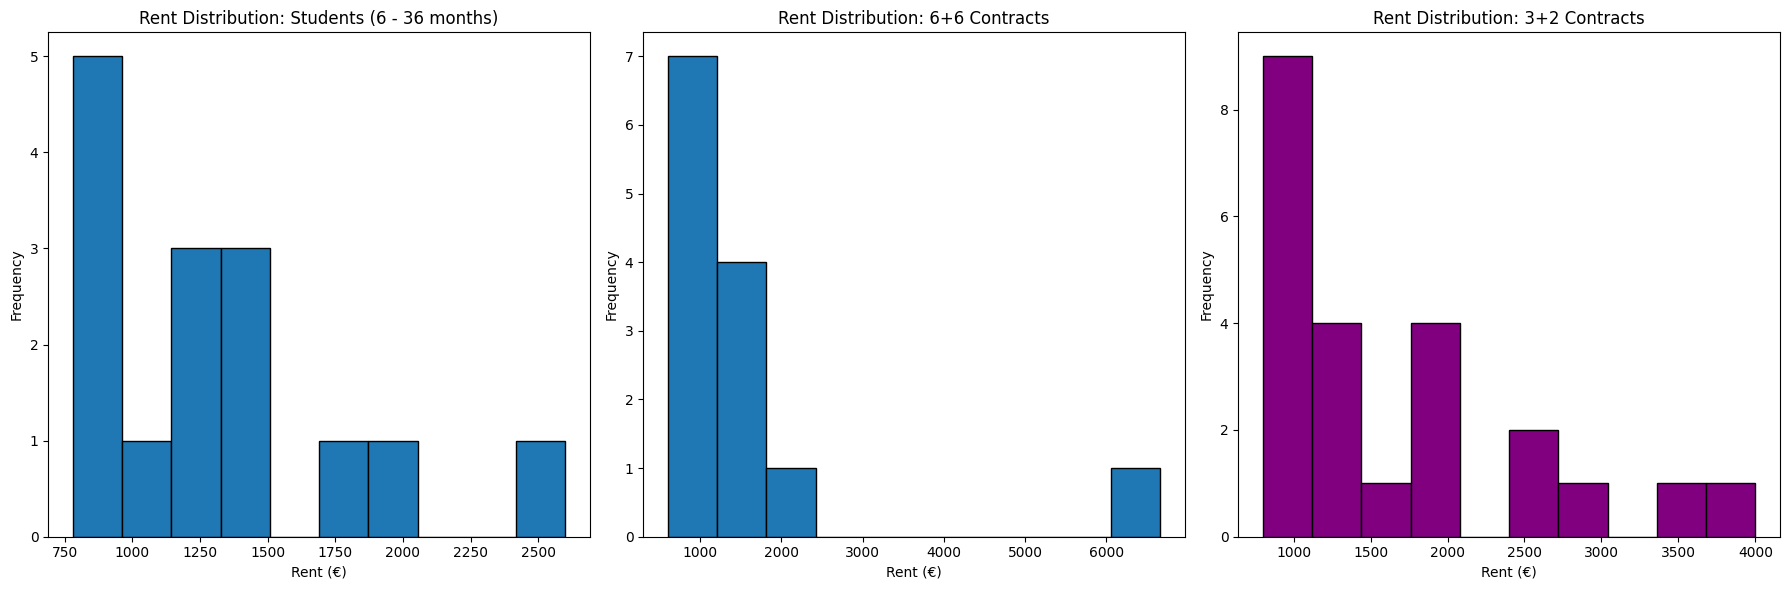

In [285]:
# Filter the train DataFrame to create the required DataFrames
student_contract = train[train['contract_type'] == 'rent | students (6 - 36 months)']
six_plus_six_contract = train[train['contract_type'] == 'rent | 6+6']
three_plus_two_contract = train[train['contract_type'] == 'rent | 3+2'] # Filter for 'rent | 3+2'

# Create a single figure for the plots
plt.figure(figsize=(18, 6))

# Plot histogram for 'rent | students (6 - 36 months)'
plt.subplot(1, 3, 1) # Changed to 1 row, 3 columns
plt.hist(student_contract['y'], bins=10, edgecolor='black')
plt.title("Rent Distribution: Students (6 - 36 months)")
plt.xlabel("Rent (€)")
plt.ylabel("Frequency")

# Plot histogram for 'rent | 6+6'
plt.subplot(1, 3, 2) # Changed to 1 row, 3 columns
plt.hist(six_plus_six_contract['y'], bins=10, edgecolor='black')
plt.title("Rent Distribution: 6+6 Contracts")
plt.xlabel("Rent (€)")
plt.ylabel("Frequency")

# Plot histogram for 'rent | 3+2'
plt.subplot(1, 3, 3) # Added a new subplot for the third distribution
plt.hist(three_plus_two_contract['y'], bins=10, edgecolor='black', color='purple') # Changed to histogram
plt.title("Rent Distribution: 3+2 Contracts")
plt.xlabel("Rent (€)")
plt.ylabel("Frequency") # Label changed back to Frequency

plt.tight_layout()
plt.show()

In [286]:
# Step 1: Combine train and test for consistent dummy encoding
combined = pd.concat([train, test], axis=0, ignore_index=True)

# Step 2: One-hot encode the original contract_type (no grouping)
contract_dummies = pd.get_dummies(combined['contract_type'], prefix='contract')

# Step 3: Re-split dummies back into train and test sets
train_dummies = contract_dummies.iloc[:len(train)].reset_index(drop=True)
test_dummies = contract_dummies.iloc[len(train):].reset_index(drop=True)

# Step 4: Add dummies back to main train and test sets (modifies them in-place)
train = pd.concat([train.reset_index(drop=True), train_dummies], axis=1)
test = pd.concat([test.reset_index(drop=True), test_dummies], axis=1)


In [287]:
train.columns

Index(['w', 'y', 'square_meters', 'contract_type', 'availability',
       'description', 'other_features', 'conditions', 'floor', 'elevator',
       'energy_efficiency_class', 'condominium_fees', 'zone',
       'availability_date', 'is_available', 'availability_encoded',
       'energy_class_num', 'energy_efficiency_class_encoded',
       'conditions_encoded', 'floor_num', 'elevator_sign', 'floor_effect',
       'total_rooms', 'num_bedrooms', 'num_other_rooms', 'num_bathrooms',
       'kitchen_open', 'kitchen_diner', 'kitchen_nook', 'kitchen_semi',
       'kitchenette', 'kitchen_none', 'suitable_disabled', 'furnished',
       'security door', 'centralized tv system', 'optic fiber',
       'window_double_glass', 'balcony', 'full day concierge',
       'video entryphone', 'window_pvc', 'closet', 'electric gate',
       'shared garden', 'window_wood', 'window_metal', 'half-day concierge',
       'cellar', 'terrace', 'partially furnished', 'alarm system', 'kitchen',
       'only kitchen fu

## 10 - Distance from center

In [288]:
!pip install unidecode

In [290]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from unidecode import unidecode
import time
import re

# Duomo coordinates
duomo_coords = (45.4642, 9.1900)
geolocator = Nominatim(user_agent="duomo_distance_calc")

# Combine zones to geocode only once
combined_zones = pd.concat([train['zone'], test['zone']]).dropna().unique()

# Geocoding helper function
def geocode_zone(zone):
    try:
        location = geolocator.geocode(f"{zone}, Milan, Italy")
        if location:
            return (location.latitude, location.longitude)
    except:
        pass

    cleaned = re.sub(r'[^\w\s]', '', unidecode(zone.lower()))
    try:
        location = geolocator.geocode(f"{cleaned}, Milan, Italy")
        if location:
            return (location.latitude, location.longitude)
    except:
        pass

    if '-' in zone:
        parts = [p.strip() for p in zone.split('-')]
        for part in parts:
            try:
                location = geolocator.geocode(f"{part}, Milan, Italy")
                if location:
                    return (location.latitude, location.longitude)
            except:
                pass
    return None

# Geocode all zones with rate limit
zone_coords = {}
for zone in combined_zones:
    zone_coords[zone] = geocode_zone(zone)
    time.sleep(1)

# Compute distance to Duomo
def compute_distance(zone):
    coords = zone_coords.get(zone)
    return geodesic(coords, duomo_coords).km if coords else None

# Add distance column directly to train and test
train['distance_to_duomo_km'] = train['zone'].apply(compute_distance)
test['distance_to_duomo_km'] = test['zone'].apply(compute_distance)

# Check remaining missing zones
print("🚨 Still missing in train:", train[train['distance_to_duomo_km'].isna()]['zone'].unique())
print("🚨 Still missing in test:", test[test['distance_to_duomo_km'].isna()]['zone'].unique())


🚨 Still missing in train: []
🚨 Still missing in test: []


In [291]:
# Get unique zones from train and test dataframes
train_zones = train['zone'].unique()
test_zones = test['zone'].unique()

# Count unique zones in each dataset
unique_train_count = len(train_zones)
unique_test_count = len(test_zones)

print(f"Number of unique zones in train: {unique_train_count}")
print(f"Number of unique zones in test: {unique_test_count}")

Number of unique zones in train: 132
Number of unique zones in test: 131


In [292]:
test['distance_to_duomo_km'].unique()

array([ 3.72175055,  1.68490204,  1.03721637,  3.77089321,  1.02623378,
        1.6377986 ,  8.05783348,  3.12963752,  2.65577914,  0.81477457,
        1.62982105, 10.22376258,  0.47432994,  2.54801628,  1.51872949,
        5.39321582,  3.97056378,  4.65212336,  2.67160098,  2.30548408,
        0.05976413,  2.33211706,  5.59821623,  1.70008945,  2.34998634,
        1.94539109,  5.20300103,  2.93308657,  2.15915754, 26.08356722,
        3.21873255,  4.19743696,  3.24592502,  4.06452138,  3.22758539,
        5.18783515,  5.35172171,  1.59217706,  1.29878709,  6.35167232,
        9.80010886,  2.52435647,  6.40116602,  4.38167408,  3.27455024,
        2.82736885,  3.59258621,  3.48419258,  1.18573536,  1.80373802,
        5.11459864,  1.21591284,  3.98200567,  1.63665532,  0.83246793,
        4.20479676,  1.2584063 ,  2.28594657,  5.71202775,  4.65154605,
        3.96458626,  5.81844658,  1.9525998 ,  4.15398813,  1.87622033,
        6.55844153,  3.16245493,  2.10098842,  4.17667183,  6.75

In [293]:
# Get unique distances and their counts in the training dataset
unique_distances_train = train['distance_to_duomo_km'].value_counts().sort_index()

# Get unique distances and their counts in the test dataset
unique_distances_test = test['distance_to_duomo_km'].value_counts().sort_index()

# Filter for distances where the count (observations) is less than 5
low_observation_distances_train = unique_distances_train[unique_distances_train < 5]
low_observation_distances_test = unique_distances_test[unique_distances_test < 5]

print("Unique Distances to Duomo (km) with < 5 Observations in TRAIN:")
if not low_observation_distances_train.empty:
    print(low_observation_distances_train.to_string())
else:
    print("No distances found with less than 5 observations in TRAIN.")

print("\nUnique Distances to Duomo (km) with < 5 Observations in TEST:")
if not low_observation_distances_test.empty:
    print(low_observation_distances_test.to_string())
else:
    print("No distances found with less than 5 observations in TEST.")

Unique Distances to Duomo (km) with < 5 Observations in TRAIN:
distance_to_duomo_km
0.615943    3
5.550023    3
6.891544    4
7.396312    4

Unique Distances to Duomo (km) with < 5 Observations in TEST:
distance_to_duomo_km
0.375025    1
0.615943    1
4.050528    2
4.196081    4
4.669673    4
4.780411    1
4.796602    2
4.841651    3
5.194416    3
5.550023    2
5.587208    4
6.025244    3
6.107163    2
6.227171    1
6.891544    4
7.141556    4
7.168479    4
7.396312    2


In [294]:
train.head(10)

,w,y,square_meters,contract_type,availability,description,other_features,conditions,floor,elevator,...,zone_encoded,zone_rent_per_sqm,contract_rent,contract_rent | 3+2,contract_rent | 4+4,contract_rent | 6+6,contract_rent | open,contract_rent | students (6 - 36 months),contract_rent | transitory,distance_to_duomo_km
0,1,3000,110,rent,unknown,"4 (2 bedrooms, 2 others), 1 bathroom - one or ...",kitchen | balcony | terrace | furnished | cell...,excellent,1,yes,...,2108.586207,27.754982,True,False,False,False,False,False,False,1.185735
1,1,2200,111,rent,available,"3 (2 bedrooms, 1 other), 1 bathroom, kitchen d...",electric gate | optic fiber | alarm system | c...,excellent,6,yes,...,1482.391304,25.720431,True,False,False,False,False,False,False,3.393469
2,1,2500,85,rent | 4+4,unknown,"3 (2 bedrooms, 1 other), 2 bathrooms, open kit...",internal exposure | balcony | full day concier...,good condition,4,yes,...,3155.200000,29.859561,False,False,True,False,False,False,False,1.258406
3,1,1250,40,rent,available,"1 room, 1 bathroom, kitchen nook",optic fiber | security door | internal exposur...,excellent,2,yes,...,2401.666667,28.065211,True,False,False,False,False,False,False,1.803738
4,1,4200,170,rent | open,available,"4 (2 bedrooms, 2 others), 3 bathrooms, kitchen...",fireplace | optic fiber | security door | balc...,excellent,4,yes,...,2019.767442,27.008401,False,False,False,False,True,False,False,2.332117
5,1,5000,220,rent | 4+4,available,"5 (4 bedrooms, 1 other), 3 bathrooms, kitchen ...",optic fiber | video entryphone | security door...,excellent,1,yes,...,2137.530120,30.191447,False,False,True,False,False,False,False,2.511646
6,1,1420,85,rent | 4+4,unknown,"3 (2 bedrooms, 1 other), 1 bathroom, semi-habi...",electric gate | optic fiber | video entryphone...,excellent,8,yes,...,1916.044444,22.567525,False,False,True,False,False,False,False,3.185660
7,1,1600,70,rent | 4+4,available,"3 (2 bedrooms, 1 other), 1 bathroom, open kitchen",electric gate | optic fiber | security door | ...,excellent,2,yes,...,1204.117647,22.095863,False,False,True,False,False,False,False,4.153988
8,1,4000,150,rent | 4+4,available,"4 (3 bedrooms, 1 other), 3 bathrooms, open kit...",electric gate | optic fiber | video entryphone...,excellent,8,yes,...,1541.320755,26.279319,False,False,True,False,False,False,False,3.218733
9,1,2400,40,rent | transitory,available from 20/04/2024,"2 (1 bedroom, 1 other), 1 bathroom, open kitchen",optic fiber | security door | external exposur...,excellent,3,no,...,1830.769231,35.211646,False,False,False,False,False,False,True,1.037216


In [295]:
a = train.columns.to_list

In [296]:
a

<bound method IndexOpsMixin.tolist of Index(['w', 'y', 'square_meters', 'contract_type', 'availability',
       'description', 'other_features', 'conditions', 'floor', 'elevator',
       'energy_efficiency_class', 'condominium_fees', 'zone',
       'availability_date', 'is_available', 'availability_encoded',
       'energy_class_num', 'energy_efficiency_class_encoded',
       'conditions_encoded', 'floor_num', 'elevator_sign', 'floor_effect',
       'total_rooms', 'num_bedrooms', 'num_other_rooms', 'num_bathrooms',
       'kitchen_open', 'kitchen_diner', 'kitchen_nook', 'kitchen_semi',
       'kitchenette', 'kitchen_none', 'suitable_disabled', 'furnished',
       'security door', 'centralized tv system', 'optic fiber',
       'window_double_glass', 'balcony', 'full day concierge',
       'video entryphone', 'window_pvc', 'closet', 'electric gate',
       'shared garden', 'window_wood', 'window_metal', 'half-day concierge',
       'cellar', 'terrace', 'partially furnished', 'alarm syste

In [299]:
# Save cleaned and imputed datasets directly in the data folder
train.to_csv(DATA_DIR / "train_preprocessed.csv", index=False)
test.to_csv(DATA_DIR / "test_preprocessed.csv", index=False)

print("✅ Preprocessed datasets saved successfully:")
print(f"  • {DATA_DIR / 'train_preprocessed.csv'}")
print(f"  • {DATA_DIR / 'test_preprocessed.csv'}")

✅ Preprocessed datasets saved successfully:
  • C:\Users\utaka\MLOPS\Final Assignment\MLOpsProject\data\train_preprocessed.csv
  • C:\Users\utaka\MLOPS\Final Assignment\MLOpsProject\data\test_preprocessed.csv
